In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# set fonts configuration - Arial
matplotlib.rcParams['font.family'] = "Open Sans"
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [4]:
def get_BLdist_MCSint(year_list):
    
    dBL = 0.5 # (K)
    BL_bins = np.arange(-35,9.5+dBL,dBL)
    BL_samples = np.zeros((2,3,len(BL_bins)))
    
    # load landsea mask
    tmp = xr.open_dataset('/neelin2020/RGMA_feature_mask/ERA5_LandSeaMask_regrid.nc4').sel(latitude=slice(-40,40))
    lsmask = tmp.landseamask    
    
    for year in year_list:

        env_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/envs_track/{}/tropics_extend/'.format(year))
        track_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
        # load non2MCS tracks
        data_track = xr.open_dataset(track_dir / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))

        files = list(env_dir.glob('mcs_era5_3D_envs_*.LD.nc'))

        print('processing year, files: {}, {}'.format(year, len(files)))

        for file in files: # sampling track by track

            data = xr.open_dataset(file)
            # 5-deg mean of BL around MCS
            # 6-deg mean of BL around MCS, matching PNNL's data
            # mean BL of MCS grids
            BL_5degAvg = 340*3/9.8*data.Buoy_TOT.sel(mcs_phase='CCS',x=slice(10,30), y=slice(10,30)).mean(('x','y')).values
            BL_6degAvg = 340*3/9.8*data.Buoy_TOT.sel(mcs_phase='CCS',x=slice(8,32), y=slice(8,32)).mean(('x','y')).values
            BL_MCS = data.Buoy_TOT.where(data.cloudtracknumber_nomergesplit > 0) # only for MCS grids
            BL_MCSAvg = 340*3/9.8*BL_MCS.sel(mcs_phase='CCS').mean(('x','y')).values

            # land or ocean?
            mcsid = int((file.name)[-11:-6])
            idt_init = data_track.sel(tracks=mcsid).idt_mcs_init
            meanlon = data_track.sel(tracks=mcsid, times=idt_init).meanlon.values
            meanlat = data_track.sel(tracks=mcsid, times=idt_init).meanlat.values

            if meanlon < 0:
                meanlon = meanlon + 360
            tmp = lsmask.sel(longitude=meanlon, latitude=meanlat, method='nearest') # landsea info
            if tmp == 100: # ocean
                ls_flag = 0
            else:
                ls_flag = 1

            # fill into the BL bins
            idx = np.argmin(abs(BL_5degAvg - BL_bins+dBL/2)) - 1
            BL_samples[ls_flag,0,idx] += 1
            idx = np.argmin(abs(BL_6degAvg - BL_bins+dBL/2)) - 1
            BL_samples[ls_flag,1,idx] += 1
            idx = np.argmin(abs(BL_MCSAvg - BL_bins+dBL/2)) - 1
            BL_samples[ls_flag,2,idx] += 1
        
    # generate xarray dataset
    ds = xr.Dataset(data_vars=dict(samples=(['surface_type','avg_type','BL_bins'], BL_samples)),
                    coords=dict(BL_bins=(['BL_bins'],BL_bins),
                                avg_type=(['avg_type'],['5degAvg','6degAvg','MCSAvg']),
                                surface_type=(['surface_type'],['ocean','land'])))
    
    return ds

In [5]:
# %%time
# year_list = np.arange(2001,2021)
# ds = get_BLdist_MCSint(year_list)

In [6]:
# # get the total tracks we have over 20 years for double-check
# test = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
# files = test.glob('*.extend.nc')
# tracks = 0
# for file in files:
#     data = xr.open_dataset(file)
#     tracks += len(data.tracks)
# print(tracks)

In [7]:
# out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats')
# ds.to_netcdf(out_dir / 'era5_BL_1Dhistogram.MCSCCS.landsea.2002-2014.nc')

#### analysis section

In [9]:
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats')
BL_climat = xr.open_dataset(out_dir / 'era5_BL_1Dhistogram.landsea.2002-2014.nc')
BL_MCSint = xr.open_dataset(out_dir / 'era5_BL_1Dhistogram.MCSint.landsea.2002-2014.nc')
BL_MCSccs = xr.open_dataset(out_dir / 'era5_BL_1Dhistogram.MCSCCS.landsea.2002-2014.nc')

In [10]:
tmp_clim_oce_5deg = BL_climat.samples.sum(('year','month')).sel(grid_type='5-deg',surface_type='ocean')
tmp_clim_land_5deg = BL_climat.samples.sum(('year','month')).sel(grid_type='5-deg',surface_type='land')
tmp_clim_oce_025deg = BL_climat.samples.sum(('year','month')).sel(grid_type='0.25-deg',surface_type='ocean')
tmp_clim_land_025deg = BL_climat.samples.sum(('year','month')).sel(grid_type='0.25-deg',surface_type='land')

tmp_mcs_5oce = BL_MCSint.samples.sel(surface_type='ocean',avg_type='5degAvg')
tmp_mcs_5land =  BL_MCSint.samples.sel(surface_type='land',avg_type='5degAvg')

# 6-deg
tmp_mcs_6oce = BL_MCSint.samples.sel(surface_type='ocean',avg_type='6degAvg')
tmp_mcs_6land =  BL_MCSint.samples.sel(surface_type='land',avg_type='6degAvg')

# MCS grids
tmp_mcs_moce = BL_MCSint.samples.sel(surface_type='ocean',avg_type='MCSAvg')
tmp_mcs_mland =  BL_MCSint.samples.sel(surface_type='land',avg_type='MCSAvg')

Text(0.5, 1.0, 'B$_{L}$ distribution, 30S-30N \n (2001-2020)')

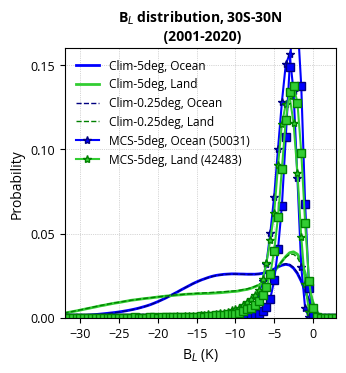

In [11]:
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ax.plot(tmp_clim_oce_5deg.BL_bins, tmp_clim_oce_5deg/tmp_clim_oce_5deg.sum(), '-', color='b', lw=2)
ax.plot(tmp_clim_land_5deg.BL_bins, tmp_clim_land_5deg/tmp_clim_land_5deg.sum(), '-', color='limegreen', lw=2)
ax.plot(tmp_clim_oce_025deg.BL_bins, tmp_clim_oce_025deg/tmp_clim_oce_025deg.sum(), '--', color='navy', lw=1, zorder=2)
ax.plot(tmp_clim_land_025deg.BL_bins, tmp_clim_land_025deg/tmp_clim_land_025deg.sum(), '--', color='green', lw=1,
       zorder=2)

ax.plot(tmp_mcs_5oce.BL_bins, tmp_mcs_5oce/tmp_mcs_5oce.sum(),marker='*', markeredgecolor='navy',color='b', lw=1.5)
ax.plot(tmp_mcs_5land.BL_bins, tmp_mcs_5land/tmp_mcs_5land.sum(),marker='*', markeredgecolor='g',color='limegreen', lw=1.5)
ax.plot(tmp_mcs_5oce.BL_bins, tmp_mcs_moce/tmp_mcs_moce.sum(),marker='s', markeredgecolor='navy',color='b', lw=1.5)
ax.plot(tmp_mcs_5land.BL_bins, tmp_mcs_mland/tmp_mcs_mland.sum(),marker='s', markeredgecolor='g',color='limegreen', lw=1.5)

ax.set_xlim([-32,3])
ax.set_xticks(np.arange(-30,5,5));
ax.set_yticks(np.linspace(0,0.2,5));
ax.set_ylim([0,0.16])
#ax2.set_ylim([0,0.2])
ax.set_xlabel('B$_{L}$ (K)',fontsize=10)
ax.set_ylabel('Probability',fontsize=10)
ax.tick_params(labelsize=9)

ax.legend(['Clim-5deg, Ocean','Clim-5deg, Land','Clim-0.25deg, Ocean','Clim-0.25deg, Land',
           'MCS-5deg, Ocean ({})'.format(int(tmp_mcs_5oce.sum()))
           ,'MCS-5deg, Land ({})'.format(int(tmp_mcs_5land.sum()))], fontsize=8.5, frameon=False);
ax.grid(linestyle=':', lw=0.5)
ax.set_title('B$_{L}$ distribution, 30S-30N \n (2001-2020)', fontsize=10, fontweight='bold')

In [ ]:
fig.savefig('/scratch/wmtsai/temp_mcs/fig/BL_distribution_climate_MCS_2001_2019.png', dpi=500,
           bbox_inches='tight', transparent=False)

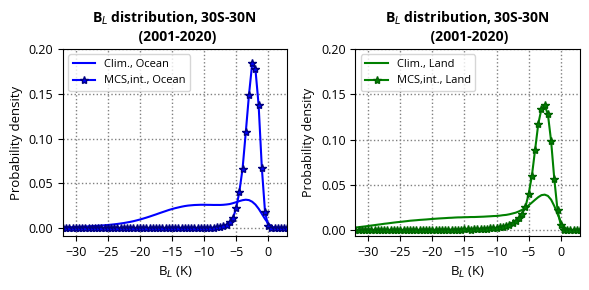

In [45]:
fig,(ax,ax2) = plt.subplots(1,2,figsize=(6,3))

ax.plot(tmp_clim_oce_5deg.BL_bins, tmp_clim_oce_5deg/tmp_clim_oce_5deg.sum(), '-', color='b', lw=1.5)
ax.plot(tmp_mcs_5oce.BL_bins, tmp_mcs_moce/tmp_mcs_moce.sum(),marker='*', markeredgecolor='navy',color='b', lw=1.5)
#ax.plot(tmp_mcs_5oce.BL_bins, tmp_mcs_moce/tmp_mcs_moce.sum(),'--' ,color='deepskyblue', lw=1.5)
ax.grid(ls=':',lw=1, color='grey')

ax.set_xlabel('B$_{L}$ (K)',fontsize=9.5)
ax.set_ylabel('Probability density',fontsize=9.5)
ax.set_title('B$_{L}$ distribution, 30S-30N \n (2001-2020)', fontsize=10, fontweight='bold')
ax.legend(['Clim., Ocean', 'MCS,int., Ocean'], fontsize=8, loc=2)
ax.tick_params(labelsize=9)
ax.set_xlim([-32,3])
ax.set_xticks(np.arange(-30,5,5));
ax.set_yticks(np.linspace(0,0.2,5));

# for land
ax2.plot(tmp_clim_land_5deg.BL_bins, tmp_clim_land_5deg/tmp_clim_land_5deg.sum(), '-', color='g', lw=1.5)
ax2.plot(tmp_mcs_5land.BL_bins, tmp_mcs_mland/tmp_mcs_mland.sum(),marker='*', markeredgecolor='darkgreen',color='g', lw=1.5)
#ax2.plot(tmp_mcs_5land.BL_bins, tmp_mcs_mland/tmp_mcs_mland.sum(),'--' ,color='limegreen', lw=1.5)
ax2.grid(ls=':',lw=1, color='grey')

ax2.set_xlabel('B$_{L}$ (K)',fontsize=9.5)
ax2.set_ylabel('Probability density',fontsize=9)
ax2.set_title('B$_{L}$ distribution, 30S-30N \n (2001-2020)', fontsize=10, fontweight='bold')
ax2.legend(['Clim., Land', 'MCS,int., Land'], fontsize=8, loc=2)
ax2.tick_params(labelsize=9)
ax2.set_xlim([-32,3])
ax2.set_xticks(np.arange(-30,5,5));
ax2.set_yticks(np.linspace(0,0.2,5));

plt.tight_layout()